In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 19W506K0189hy4MbJFmSZElrWx6n_kPfc

Mounted at /content/gdrive/
Downloading...
From: https://drive.google.com/uc?id=19W506K0189hy4MbJFmSZElrWx6n_kPfc
To: /content/LargeMovieReviewDataset.csv
66.2MB [00:00, 128MB/s] 


 # Dependencies

In [2]:
!python3 -m spacy download en_core_web_md
!pip install unidecode
!pip install word2number
!pip install contractions
!pip install pyspellchecker

     |████████████████████████████████| 96.4 MB 1.1 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=23323dce1fd0688930db61e4f7cb3e65a4d246650dedabcb1290a17f88a71b26
  Stored in directory: /tmp/pip-ephem-wheel-cache-3uw66j3m/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
     |████████████████████████████████| 241 kB 5.2 MB/s 
  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5580 sha256=97bcdd3518aaa0eac8f1fef3b5eb96d0a92145e02cf15594ca3b016b52e911cb
  Stored in directory: /root/.cache/pip/wheels/4b/c3/77/a5f48aeb0d3efb7cd5ad61cbd3da30bbf9ffc9662b07c9f879
Successfully built word2number
     |████████████████████████████████| 321 kB 4.8 MB/s 
     |████████████████████████████████| 283 kB 48.0 MB/s 
  Created wheel for pyahocorasick: filename=pya

In [3]:
import numpy as np
from numpy import interp
import pandas as pd
import scipy
from itertools import cycle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import string

In [4]:
from spellchecker import SpellChecker
import nltk
import json
from bs4 import BeautifulSoup
import re
import spacy
import en_core_web_sm
import unidecode
from word2number import w2n
import contractions
from wordcloud import WordCloud
from gensim.models import Word2Vec

import pickle

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
nlp = en_core_web_sm.load()
ps = nltk.stem.PorterStemmer()
spell = SpellChecker()

In [7]:
OUTPUT_FOLDER = "/content/gdrive/MyDrive/EPAM/Week 6. NLP/HW/"

# Support

In [8]:
def coefs_importance(coefs, labels):
    df = pd.DataFrame(zip(coefs, labels), columns=['coefs', 'labels'])
    df.sort_values(by="coefs", inplace=True)
    df.reset_index(inplace=True, drop=True)

    df = df.iloc[np.concatenate([np.array([0,1,2,3,4]), df.index[-5:].values])]

    plt.figure(figsize=(12,7))
    sns.barplot(x="coefs", y="labels", data=df)
    plt.title("importance")
    plt.show()

In [9]:
def roc_graph(y_test_bin, predict_proba, n_classes):

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predict_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), predict_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(15,8))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC for multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [10]:
def cv_curve(param_name, mean_test, std_test, mean_train, std_train, param_val, x_type, param_scale="log"):
    #try:
    #    param_val.sort()
    #except:
    #    pass
    lower_b_tt = mean_test - 2*std_test
    upper_b_tt= mean_test + 2*std_test
    
    lower_b_tn = mean_train - 2*std_train
    upper_b_tn = mean_train + 2*std_train
    
    f = plt.figure(figsize=(13,5))
    plt.title('choose ' + param_name)
    
    if x_type == 'O':
        plt.plot(range(len(param_val)), mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(range(len(param_val)), lower_b_tt, label='test lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tt, label='test upper bound', color='b', lw=2, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)

        plt.plot(range(len(param_val)), mean_train, label='train mean values of score', color='gray', lw=1)
        plt.plot(range(len(param_val)), lower_b_tn, label='train lower bound', color='gray', lw=1, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tn, label='train upper bound', color='gray', lw=1, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)
    else:
        if param_scale =='log':
            plt.xscale('log')
        plt.plot(param_val, mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(param_val, lower_b_t, label='lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(param_val, upper_b_t, label='upper bound', color='b', lw=2, linestyle='dashed')
    legend_box = plt.legend(framealpha=1).get_frame()
    legend_box.set_facecolor('white')
    legend_box.set_edgecolor('red')
    plt.xlabel('parameter')
    plt.ylabel('accuracy')
    plt.show()

In [11]:
def conf_matrix(y_test, predict, model_name):
    conf = confusion_matrix(y_test, predict)
    fig, ax = plt.subplots(figsize=(10,7))
    sns.heatmap(conf /np.sum(conf,axis=1), # 
                annot=conf/np.sum(conf,axis=1), #  normalized by true class sizes
                yticklabels=["Positive", "Negative"],
                xticklabels=["Positive", "Negative"],
                linewidths=0.5, cmap = 'vlag', 
                ax=ax)
    plt.title(model_name+' confusion matrix');
    plt.xlabel('Predicted label');
    plt.ylabel('True label');

In [12]:
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text


def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())


def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text


def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text

In [13]:
def spelling(list_):
    """check and correct misspelling"""
    # check for misspelling
    misspelled = spell.unknown(list_)
    indexes = [i for i, e in enumerate(list_) if e in misspelled]
    for i, word in enumerate(np.array(list_)[indexes]):
        # Get the one `most likely` answer
        list_[indexes[i]] = spell.correction(word)
    return list_

In [14]:
def check(text, stop_words, punctuations, special_chars, remove_num):
    # redundant fucntionality
    doc = nlp(text)
    iteration = []

    for token in doc:
        flag = True
        # remove stop words
        if stop_words and token.is_stop and token.pos_ != 'NUM': 
            flag = False

        # remove punctuations
        if punctuations and token.pos_ == 'PUNCT' and flag == True: 
            flag = False

        # remove special characters
        if special_chars and token.pos_ == 'SYM' and flag == True: 
            flag = False

        # remove numbers
        if remove_num and (token.pos_ == 'NUM' or token.text.isnumeric()) \
        and flag == True:
            flag = False

        if flag:
            iteration.append(token.text)
    # check for misspelling
    iteration = spelling(iteration)
    text =  " ".join(iteration)
    return text

In [15]:
def text_preprocessing(text, accented_chars=True, contractions=True, 
                       convert_num=True, extra_whitespace=True, remove_uls=True,
                       lemmatization=True, lowercase=True, punctuations=True,
                       remove_html=True, remove_num=True, special_chars=True, 
                       stop_words=True, stemmer=False, remove_ents=True):
    """preprocess text"""

    # remove html tags
    if remove_html: 
        text = strip_html_tags(text)
    
    # remove accented characters
    if accented_chars: 
        text = remove_accented_chars(text)
    
    # expand contractions
    if contractions: 
        text = expand_contractions(text)

    # remove ents
    # may be it's a good idea maybe not. let's try
    # P.S. okey, it's not a good idea 
    # may be it's better to add them as token without preprocessing
    if remove_ents:
        doc = nlp(text)
        for token in doc.ents:
            text = text.replace(token.text, '')

    # remove urls and repeating chars
    if remove_uls:
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'www\S+', '', text)
        text = re.sub(r'^[aAeEiIoOuU]{3,}', '', text)
        text = re.sub(r'.[aAeEiIoOuU]{3,}', '', text)

    # remove extra whitespaces
    if extra_whitespace: 
        text = remove_whitespace(text)

    # convert all characters to lowercase
    if lowercase: 
        text = text.lower()  

    # check conditions and misspelling detection
    text = check(text, stop_words, punctuations, special_chars, remove_num)

    doc = nlp(text)
    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text

        # convert tokens to base form
        if lemmatization and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_

        # cut tokens using stemmer
        if stemmer and token.lemma_ != "-PRON-" and flag == True:
            edit = ps.stem(token.text)

        # append tokens edited and not removed to list 
        if edit != "" and flag == True:
            clean_text.append(edit)

    clean_text =  " ".join(clean_text)

    return clean_text

In [16]:
def text_preprocessing_save(data, pretrained=True, train_set=True):
    if pretrained:
        if train_set:
            my_file = open("/content/gdrive/MyDrive/EPAM/Week 6. NLP/HW/data/preproc_text_train.txt", "r")
            prepoc_text = my_file.readlines()
            return prepoc_text
        else:
            my_file = open("/content/gdrive/MyDrive/EPAM/Week 6. NLP/HW/data/preproc_text_test.txt", "r")
            prepoc_text = my_file.readlines()
            return prepoc_text
    else:
        prepoc_text = [text_preprocessing(text = x) for x in data.review.values]
        if train_set:
            textfile = open("/content/gdrive/MyDrive/EPAM/Week 6. NLP/HW/data/preproc_text_train.txt", "w")
            for element in prepoc_text:
                textfile.write(element + "\n")
            textfile.close()
        else:
            textfile = open("/content/gdrive/MyDrive/EPAM/Week 6. NLP/HW/data/preproc_text_test.txt", "w")
            for element in prepoc_text:
                textfile.write(element + "\n")
            textfile.close()
        return prepoc_text

# Preprocessing

In [17]:
# Read dataset
data = pd.read_csv("./LargeMovieReviewDataset.csv")

# Convert sentiment column to binary
data.loc[:, "sentiment"] = data.loc[:, "sentiment"].apply(lambda sentiment: True if sentiment=='positive' else False)

In [ ]:
print("Positive reviews:")
print('-------')
for review in data.loc[data['sentiment'] == True, ["review"]].iloc[:3].values:
    for i in np.arange(0, min(500, len(review[0])), 100):
        print(review[0][i:i+100])
    print('-------')

Positive reviews:
-------
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The
y are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo
ut Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Tru
st me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to
 drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ
-------
A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-B
BC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece
. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" 
but he has all the voices down pat too! You can truly see the seamless editing guided by the referen
ces to Williams' diary entries, not only is it well worth

In [ ]:
print("Negative reviews:")
for review in data.loc[data['sentiment'] == False, ["review"]].iloc[:3].values:
    for i in np.arange(0, min(500, len(review[0])), 100):
        print(review[0][i:i+100])
    print('-------')

Negative reviews:
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his par
ents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, J
ake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to ma
ke a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents a
re divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins 
-------
This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 
years were brilliant, but things dropped off after that. By 1990, the show was not really funny anym
ore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It
's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances ar
e almost as bad - if not for the mildly entertaining respite of t

In [18]:
# Get training set
train_data = data.iloc[:int(len(data)*0.7)]

# Get testing set
test_data = data.iloc[int(len(data)*0.7):]

# fraction of positive sentiments in train set
FRAC_POS_REW = train_data.sentiment.mean()
print(f"fraction of positive reviews: {FRAC_POS_REW:0.03}")

fraction of positive reviews: 0.5


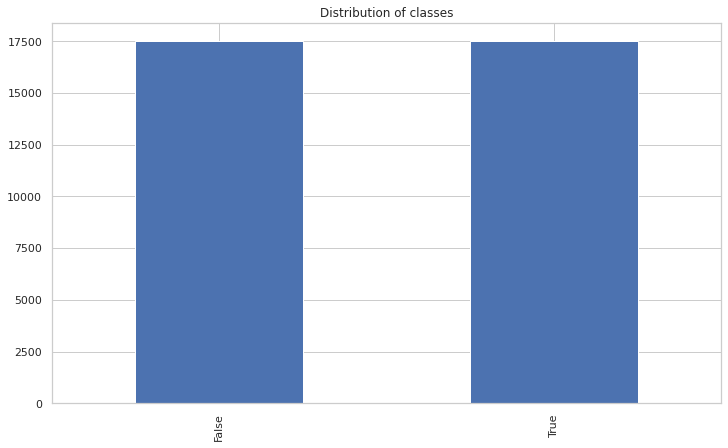

In [ ]:
# classes are balanced
# we are able to freely use accuracy or roc-auc metrics
fig, ax = plt.subplots(figsize=(12,7))
train_data.sentiment.value_counts().plot.bar(ax=ax)
plt.title("Distribution of classes")
plt.show()

In [19]:
%%time
# doing prepocessing for train and test sets
preproc_text_train = text_preprocessing_save(data=train_data, pretrained=True, train_set=True)
preproc_text_test = text_preprocessing_save(data=test_data, pretrained=True, train_set=False)

CPU times: user 42.4 ms, sys: 21.3 ms, total: 63.7 ms
Wall time: 1.64 s


In [20]:
train_data.loc[:, "preproc_text"] = preproc_text_train
train_data.reset_index(inplace=True, drop=True)

test_data.loc[:, "preproc_text"] = preproc_text_test
test_data.reset_index(inplace=True, drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


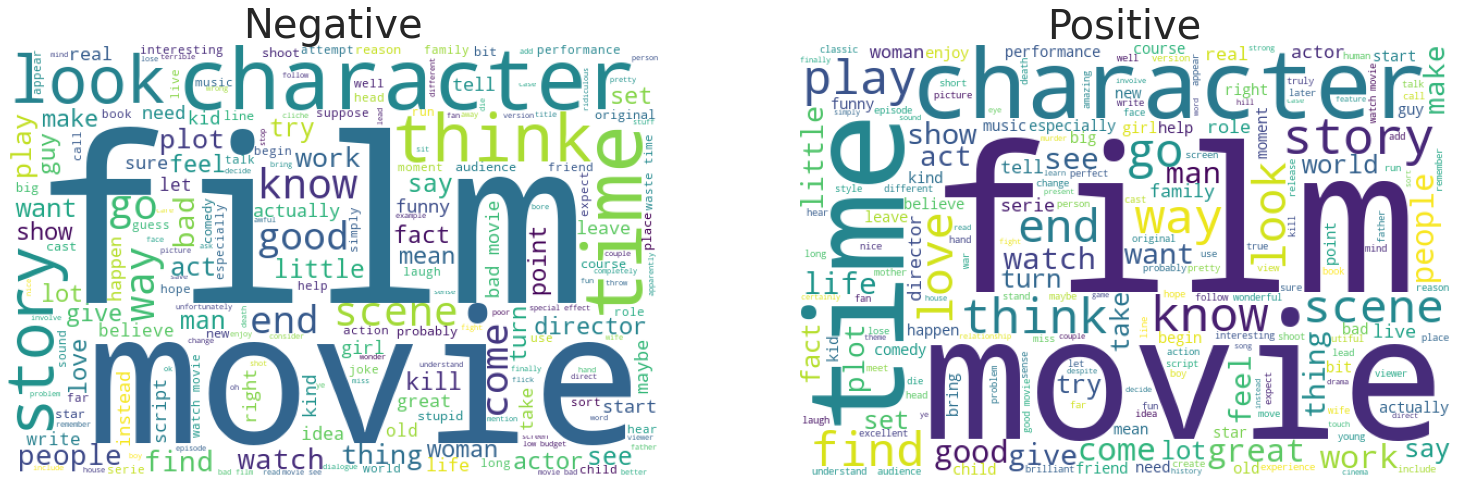

In [ ]:
# using wordcloud lib for word visualization
# as we can see there are a lot of common words in both subsets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(train_data.preproc_text[~train_data['sentiment']]))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Negative',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(train_data.preproc_text[train_data['sentiment']]))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Positive',fontsize=40);

In [28]:
# create y_test_bin for roc-auc visualization 
# the only purpose for that procedure is to use function 
# for visualization roc-auc that was written for the multiclass task
test_data.loc[:, "col1"] = 0
test_data.loc[:, "col2"] = 0
test_data.loc[test_data.sentiment, "col1"] = 1
test_data.loc[~test_data.sentiment, "col2"] = 1
y_test_bin = test_data.loc[:, ['col1', 'col2']].values
test_data.drop(columns=["col1", "col2"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

# Home-made Bayes

Predict on Test Set:  
$$ P(\text{POS} | \text{nice movie guys, highly recommend"}) $$
$$\propto P(\text{"nice movie guys, highly recommend"} | \text{POS}) \times P(\text{POS}) $$
$$= P(\text{"nice"} | \text{POS}) \times P(\text{"movie"} | \text{POS}) \times \dots \times P(\text{POS})$$  
Due to numerical issues, equivalently compute:  
  
$$log(P(\text{"nice"} | \text{POS}) \times P(\text{"movie"} | \text{POS}) \times \dots \times P(\text{POS}))$$
$$ = log(P(\text{"nice"} | \text{POS})) + log(P(\text{"movie"} | \text{POS})) + \dots + log(P(\text{POS}))$$

In [ ]:
def word_freq_bow(train_data, recalc=False):
    if recalc:
        # Get all words from pos and neg datasets
        train_pos_words = ' '.join(train_data[train_data.sentiment == True].preproc_text).split(' ')
        train_neg_words = ' '.join(train_data[train_data.sentiment == False].preproc_text).split(' ')

        # get common words from train_pos_words and train_neg_worёds
        common_words = set(train_pos_words).intersection(set(train_neg_words))

        # calculate probs for common word in train_pos_words
        train_pos_bow = dict()
        for w in common_words:
            train_pos_bow[w] = train_pos_words.count(w) / len(train_pos_words)

        # create json object from dictionary
        train_pos_bow_json = json.dumps(train_pos_bow)
        # and write it into file
        f = open("/content/gdrive/MyDrive/EPAM/Week 6. NLP/HW/data/train_pos_bow.json","w")
        f.write(train_pos_bow_json)
        f.close()


        # calculate probs for common word in train_neg_words
        train_neg_bow = dict()
        for w in common_words:
            train_neg_bow[w] = train_neg_words.count(w) / len(train_neg_words)

        # create json object from dictionary
        train_neg_bow_json = json.dumps(train_neg_bow)
        # and write it into file
        f = open("/content/gdrive/MyDrive/EPAM/Week 6. NLP/HW/data/train_neg_bow.json","w")
        f.write(train_neg_bow_json)
        f.close()
        return train_pos_bow, train_neg_bow
    else:
        with open(file="/content/gdrive/MyDrive/EPAM/Week 6. NLP/HW/data/train_pos_bow.json", mode="r") as data_file:
            train_pos_bow = json.load(data_file)

        with open(file="/content/gdrive/MyDrive/EPAM/Week 6. NLP/HW/data/train_neg_bow.json", mode="r") as data_file:
            train_neg_bow = json.load(data_file)
        return train_pos_bow, train_neg_bow

In [ ]:
def predict_text(t, verbose=False):
    # if some word doesnt appear in either pos or neg BOW, disregard it
    valid_words = [w for w in t if w in train_pos_bow]
    
    # get the probabilities of each valid word showing up in pos and neg BOW
    pos_probs = [train_pos_bow[w] for w in valid_words]
    neg_probs = [train_neg_bow[w] for w in valid_words]
    
    # print probs if requested
    if verbose:
        data_df = pd.DataFrame()
        data_df['word'] = valid_words
        data_df['pos_prob'] = pos_probs
        data_df['neg_prob'] = neg_probs
        data_df['ratio'] = [s/n if n > 0 else np.inf for s,n in zip(pos_probs, neg_probs)]
        print(data_df.head(10))
     
    # calculate pos score as sum of logs for all probabilities
    pos_score = sum([np.log(p) for p in pos_probs]) + np.log(FRAC_POS_REW)
    
    # calculate neg score as sum of logs for all probabilities
    neg_score = sum([np.log(p) for p in neg_probs]) + np.log(1-FRAC_POS_REW)
    
    # if verbose, report the two scores
    if verbose:
        print('Pos Score: %s'%pos_score)
        print('Neg Score: %s'%neg_score)
        if pos_score >= neg_score:
            print("sentiment of the review is positive")
        else:
            print("sentiment of the review is negative")    
        
    return (pos_score >= neg_score)

In [ ]:
train_pos_bow, train_neg_bow = word_freq_bow(train_data, recalc=False)

In [ ]:
predict_text(train_data["preproc_text"][0].split(), verbose=True)

       word  pos_prob  neg_prob     ratio
0  reviewer  0.000187  0.000220  0.853200
1   mention  0.000490  0.000676  0.724703
2     watch  0.005763  0.006730  0.856386
3   episode  0.001381  0.000815  1.695059
4      hook  0.000144  0.000091  1.570823
5     right  0.001603  0.001525  1.051620
6   exactly  0.000407  0.000475  0.857525
7    happen  0.001399  0.001754  0.797706
8     thing  0.003121  0.004281  0.729054
9    strike  0.000267  0.000180  1.485142
Pos Score: -955.1740893449971
Neg Score: -965.1660540505659
sentiment of the review is positive


True

In [ ]:
predictions = test_data.preproc_text.apply(lambda t: predict_text(t.split()))

In [ ]:
print(classification_report(test_data.sentiment, predictions, 
                            target_names=["negative", "positive"])
)

              precision    recall  f1-score   support

    negative       0.86      0.88      0.87      7490
    positive       0.88      0.86      0.87      7510

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



Simple implementation of Naive Bayes give us pretty good results

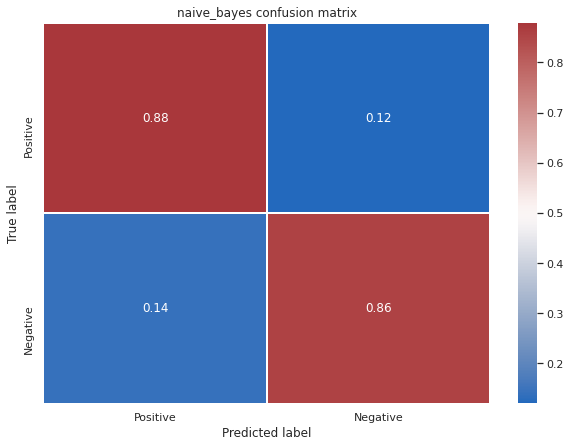

In [ ]:
conf_matrix(y_test=test_data.sentiment, predict=predictions, model_name="naive_bayes")

# MultinomialNB

In [ ]:
# bow
count_vect = CountVectorizer()
# tf-idf
tfidf_transformer = TfidfTransformer()

# vectirize input train data (simple BOW)
X_train_counts = count_vect.fit_transform(train_data.preproc_text)
# transform test
X_test_counts = count_vect.transform(test_data.preproc_text)

# fit_transform train bow to tfidf  
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# transform test
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# fit MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_tfidf, train_data.sentiment)

MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice).

In [ ]:
predicted = clf.predict(X_test_tfidf)

In [ ]:
print(classification_report(test_data.sentiment, predicted))

              precision    recall  f1-score   support

       False       0.86      0.85      0.86      7490
        True       0.86      0.86      0.86      7510

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



It works like a home-made Bayes

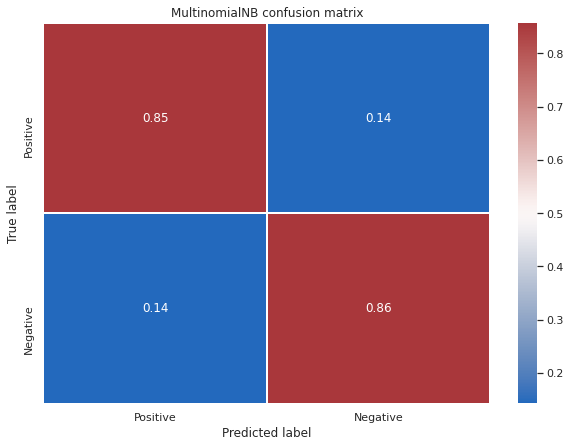

In [ ]:
conf_matrix(y_test=test_data.sentiment, predict=predicted, model_name="MultinomialNB")

## Pipeline + GS

In [ ]:
# Now it's time to add a little bit of tuning
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
    ])

# test differnet gram ranges, tf or tf-idf and regularisation
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
}

# classes are balanced, scorring = accuracy 
gs_clf = GridSearchCV(text_clf, 
                      parameters, 
                      cv=5, 
                      n_jobs=-1,
                      scoring = 'accuracy', 
                      return_train_score=True)

In [ ]:
gs_clf.fit(train_data.preproc_text, train_data.sentiment)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

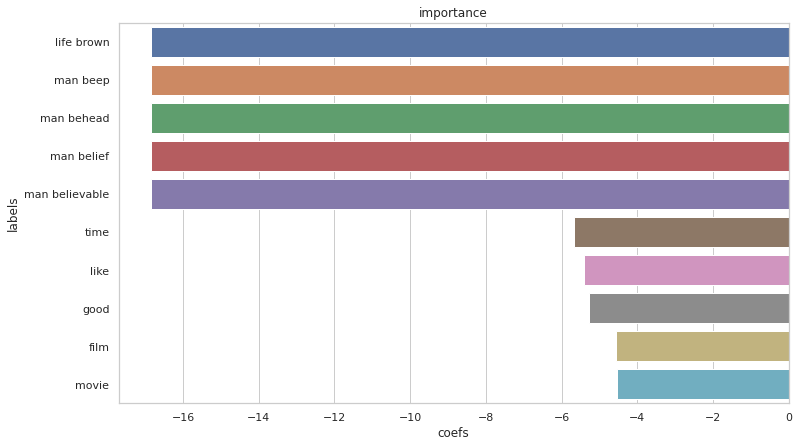

In [ ]:
# importances of coefs are fancy
coefs = gs_clf.best_estimator_.get_params()["steps"][-1][1].coef_[0]
labels = gs_clf.best_estimator_.get_params()["steps"][0][1].get_feature_names()

coefs_importance(coefs, labels)

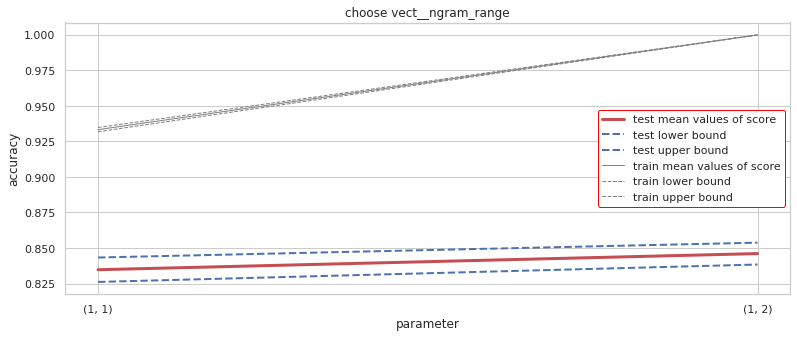

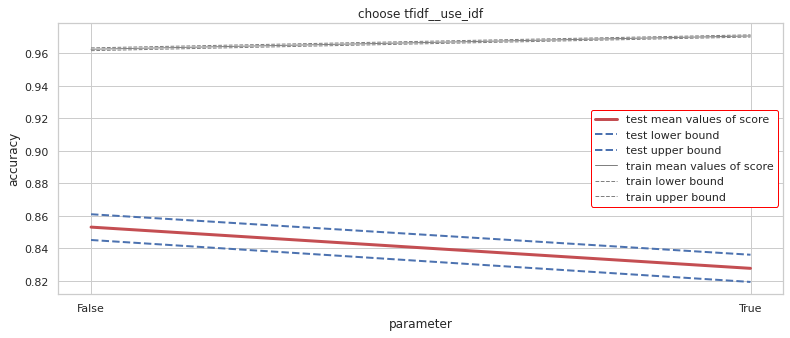

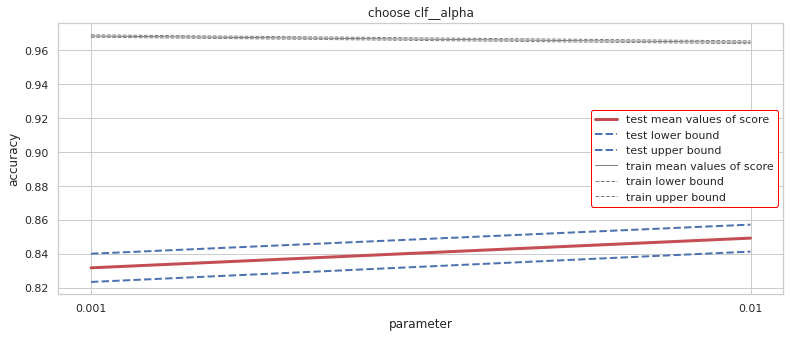

In [ ]:
# Drawing validation curves 
rs_df = pd.DataFrame(gs_clf.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)

for element in list(parameters.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

It will be a good idea to add more powerfull regularisation to model

In [ ]:
predicted = gs_clf.best_estimator_.predict(test_data.preproc_text)
predicted_proba = gs_clf.best_estimator_.predict_proba(test_data.preproc_text)

In [ ]:
print(classification_report(test_data.sentiment, predicted, 
                            target_names=["negative", "positive"])
)

              precision    recall  f1-score   support

    negative       0.86      0.87      0.86      7490
    positive       0.87      0.86      0.86      7510

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



Quality is better then in previous one, but still far from perfect

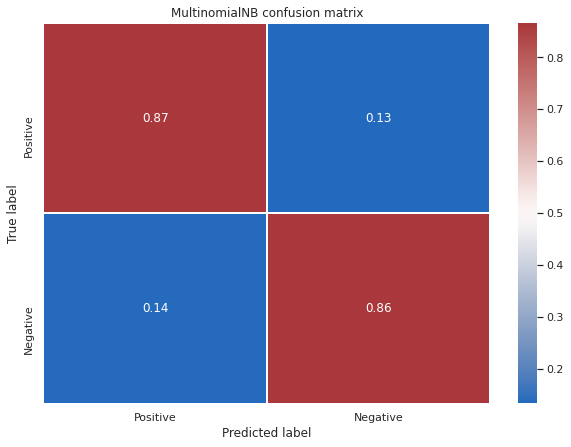

In [ ]:
conf_matrix(y_test=test_data.sentiment, predict=predicted, model_name="MultinomialNB")

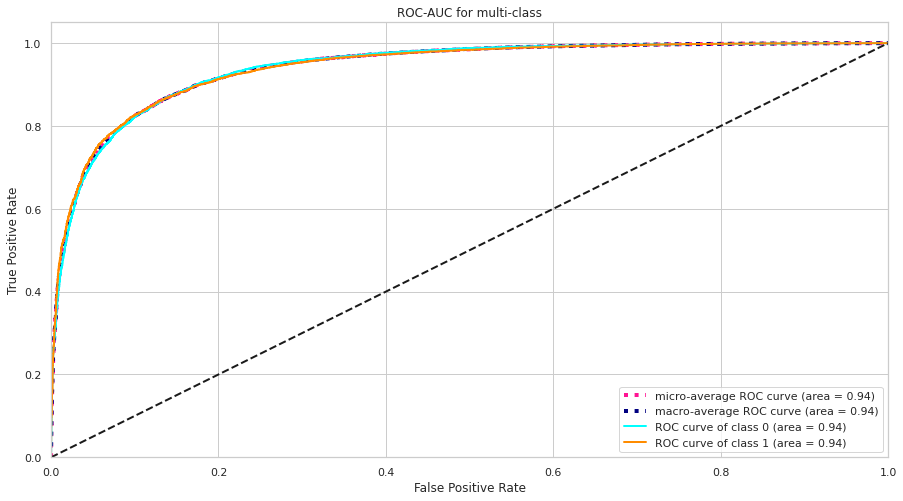

In [ ]:
roc_graph(y_test_bin=y_test_bin, predict_proba=1 - predicted_proba, n_classes=2)

# SGDClassifier

In [ ]:
# logistic regression with penalty l2
sgd = SGDClassifier(loss='log', penalty='l2')

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', sgd)
    ])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1, 10)
    }

gs_clf = GridSearchCV(text_clf, 
                      parameters, 
                      cv=5, 
                      n_jobs=-1,
                      scoring = 'accuracy',
                      return_train_score=True)

In [ ]:
gs_clf.fit(train_data.preproc_text, train_data.sentiment)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

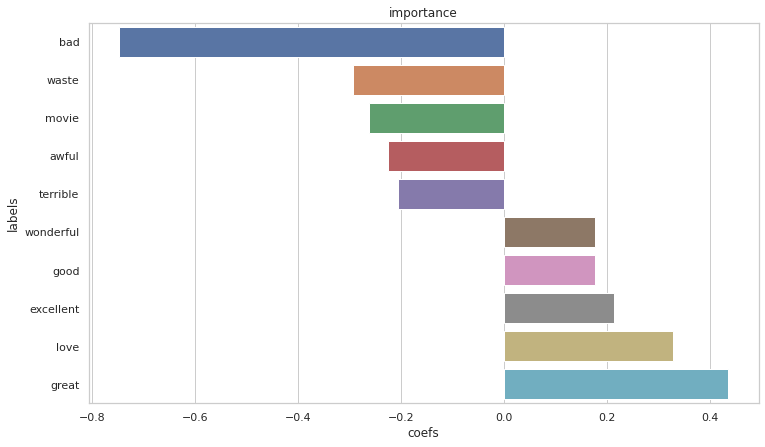

In [ ]:
# coef are easy to interpret
# but its kinda strange to see in top 5 such feature as movie
coefs = gs_clf.best_estimator_.get_params()["steps"][-1][1].coef_[0]
labels = gs_clf.best_estimator_.get_params()["steps"][0][1].get_feature_names()

coefs_importance(coefs, labels)

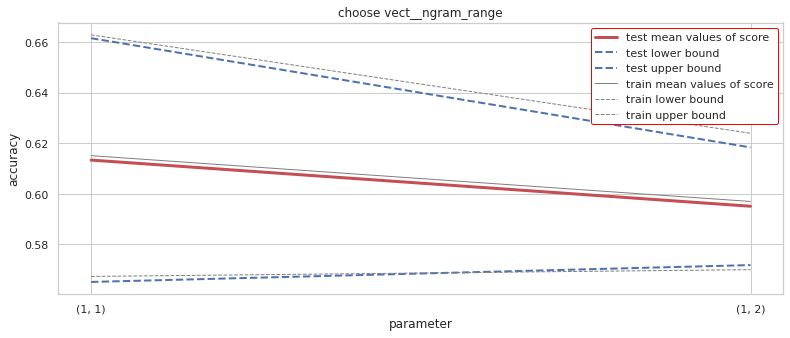

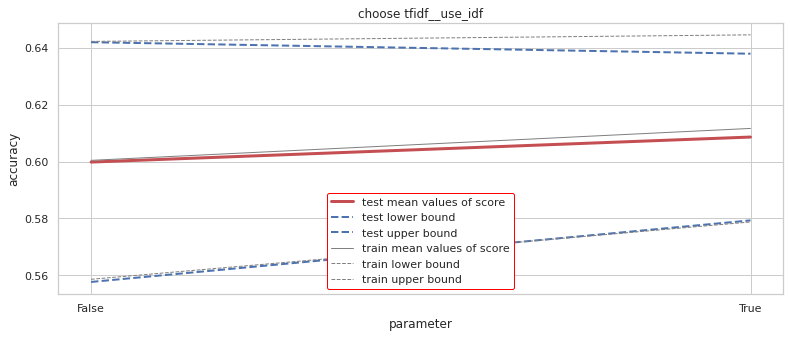

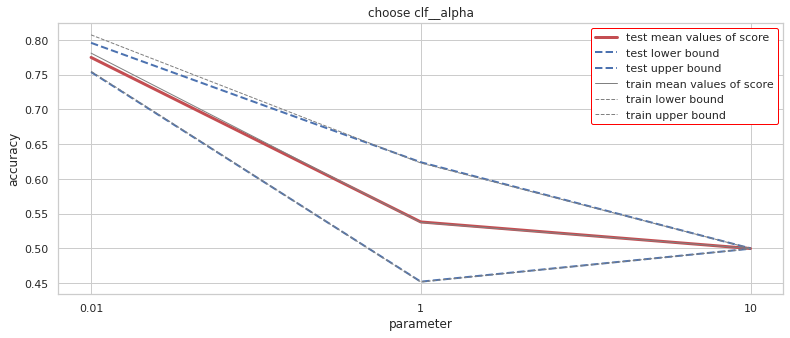

In [ ]:
# Drawing validation curves 
rs_df = pd.DataFrame(gs_clf.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)

for element in list(parameters.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

In [ ]:
predicted = gs_clf.best_estimator_.predict(test_data.preproc_text)
predicted_proba = gs_clf.best_estimator_.predict_proba(test_data.preproc_text)

In [ ]:
print(classification_report(test_data.sentiment, predicted))

              precision    recall  f1-score   support

       False       0.83      0.80      0.82      7490
        True       0.81      0.83      0.82      7510

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000



Bayes looks much more better then logreg

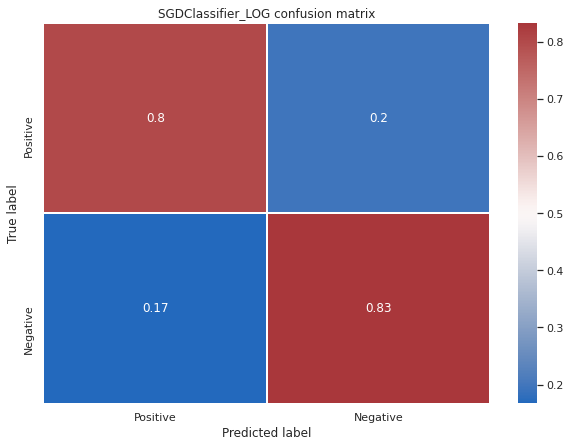

In [ ]:
conf_matrix(y_test=test_data.sentiment, predict=predicted, model_name="SGDClassifier_LOG")

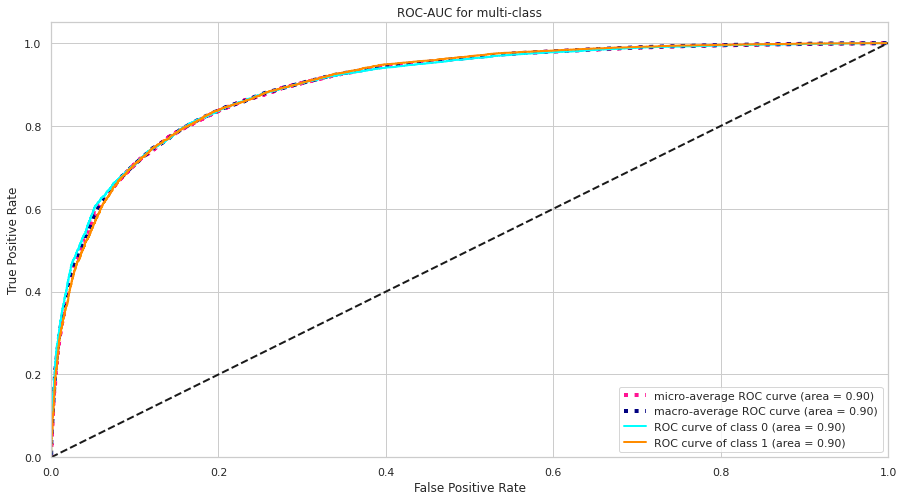

In [ ]:
roc_graph(y_test_bin=y_test_bin, predict_proba=1-predicted_proba, n_classes=2)

# SVM

In [ ]:
# Due to computational issues I wont use gridsearch for svc
# and I use linear kernel for the same reason
svc = svm.SVC(C=1e-2, kernel="linear")

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', svc)
    ])

In [ ]:
text_clf.fit(train_data.preproc_text, train_data.sentiment)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=0.01, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_

In [ ]:
# save the model to disk
filename = OUTPUT_FOLDER+'/svm.sav'
pickle.dump(text_clf, open(filename, 'wb'))

In [24]:
# load the model from disk
filename = OUTPUT_FOLDER+'/svm.sav'
text_clf = pickle.load(open(filename, 'rb'))

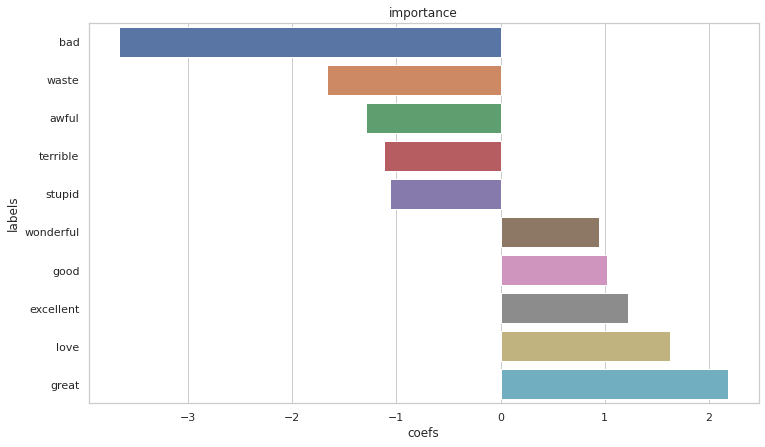

In [ ]:
# It seems really good, take my postive sentiment
coefs = text_clf.get_params()["steps"][-1][1].coef_.toarray()[0]
labels = text_clf.get_params()["steps"][0][1].get_feature_names()

coefs_importance(coefs, labels)

In [25]:
%%time
predicted = text_clf.predict(test_data.preproc_text)

CPU times: user 5min 51s, sys: 94 ms, total: 5min 51s
Wall time: 5min 49s


In [ ]:
print(classification_report(test_data.sentiment, predicted))

              precision    recall  f1-score   support

       False       0.90      0.69      0.78      7490
        True       0.75      0.93      0.83      7510

    accuracy                           0.81     15000
   macro avg       0.83      0.81      0.81     15000
weighted avg       0.83      0.81      0.81     15000



Okay, here we've got horrible results. Seems like our model is too conservative in predicting negative class

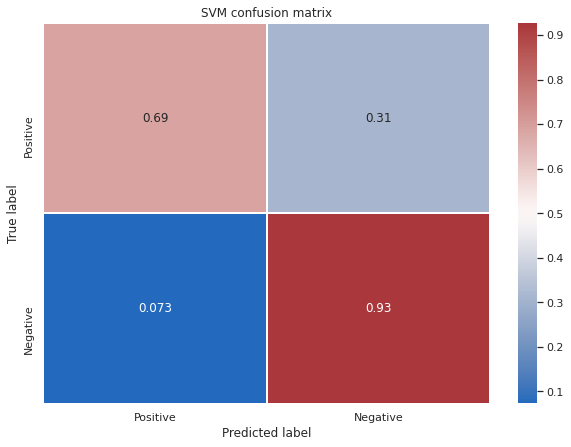

In [ ]:
conf_matrix(y_test=test_data.sentiment, predict=predicted, model_name="SVM")

In [33]:
# ROC-AUC score relatively low if we will compare to Bayes results
roc_auc_score(test_data.sentiment, text_clf.decision_function(test_data.preproc_text))

0.9148154574497022

# Word2Vec

In [ ]:
size = 2500
window = 3
min_count = 1
workers = 3
sg = 1

# Store the model in following file
word2vec_model_file = OUTPUT_FOLDER + '/word2vec_' + str(size) + '.model'
# Store the vectors for train data in following file
word2vec_filename = OUTPUT_FOLDER + '/train_review_word2vec.csv'

In [ ]:
import time
train_data.loc[:, "preproc_tokens"] = train_data.loc[:, "preproc_text"].apply(lambda x: x.split(' ')).values
test_data.loc[:, "preproc_tokens"] = test_data.loc[:, "preproc_text"].apply(lambda x: x.split(' ')).values

start_time = time.time()
preproc_tokens = pd.Series(train_data['preproc_tokens']).values
# Train the Word2Vec Model
w2v_model = Word2Vec(preproc_tokens, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Time taken to train word2vec model: 312.3018605709076


In [ ]:
# Load the model from the model file
sg_w2v_model = Word2Vec.load(word2vec_model_file)

In [ ]:
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in train_data.iterrows():
        model_vector = (np.mean([sg_w2v_model[token] for token in row['preproc_tokens']], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(x) for x in range(2500))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(2500)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Load from the filename
word2vec_df = pd.read_csv(word2vec_filename)

In [ ]:
# fit logreg
text_clf = LogisticRegression(max_iter=1000)

parameters = {
    'C': (1e-2, 1e-3, 1, 10)
}

gs_clf = GridSearchCV(text_clf, 
                      parameters, 
                      cv=5, 
                      scoring = 'accuracy', 
                      return_train_score=True)

In [ ]:
start_time = time.time()
# Fit the model
gs_clf.fit(word2vec_df, train_data['sentiment'])
print("Time taken to fit the model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the model with word2vec vectors: 180.4915919303894


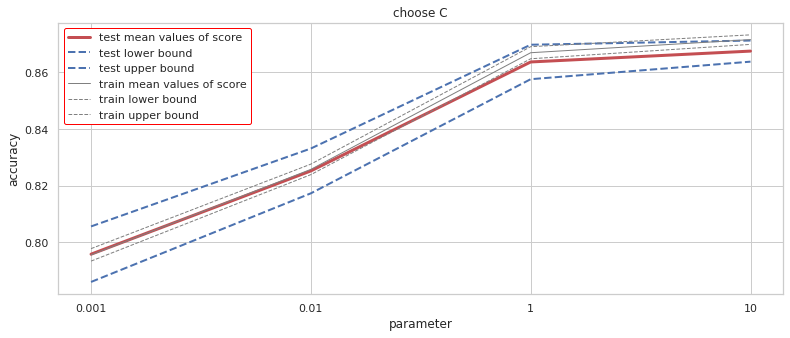

In [ ]:
# Drawing validation curves 
rs_df = pd.DataFrame(gs_clf.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)

for element in list(parameters.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

In [ ]:
test_features_word2vec = []
for index, row in test_data.iterrows():
    model_vector = np.mean([sg_w2v_model[token] for token in row['preproc_tokens'] if token in sg_w2v_model.wv.vocab], axis=0)
    if type(model_vector) is np.ndarray:
        test_features_word2vec.append(model_vector)
    else:
        test_features_word2vec.append(np.array([0 for i in range(2500)]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test_predictions_word2vec = gs_clf.predict(test_features_word2vec)
test_predictions_word2vec_proba = gs_clf.predict_proba(test_features_word2vec)

In [ ]:
print(classification_report(test_predictions_word2vec, test_data['sentiment']))

              precision    recall  f1-score   support

       False       0.86      0.87      0.86      7389
        True       0.87      0.86      0.87      7611

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



We reduced the dimension to 2500 without loss of quality

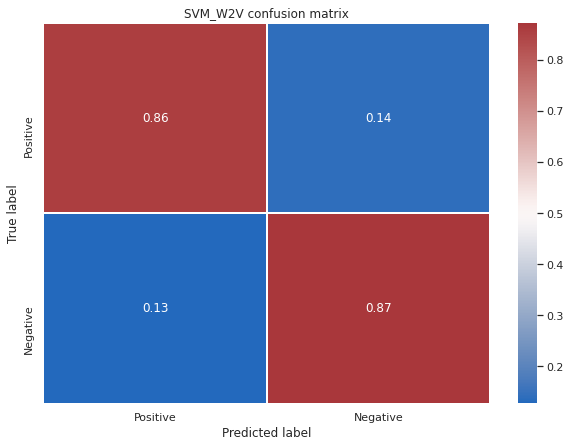

In [ ]:
conf_matrix(y_test=test_data.sentiment, predict=test_predictions_word2vec, model_name="SVM_W2V")

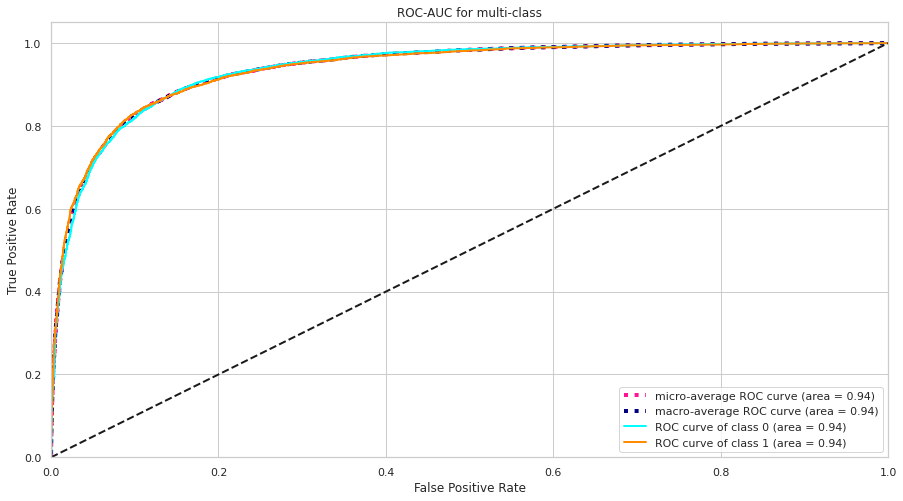

In [ ]:
roc_graph(y_test_bin=y_test_bin, predict_proba=1-test_predictions_word2vec_proba, n_classes=2)